In [25]:
import numpy as np
from pathlib import Path
import yourdfpy
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

project_root = Path.home() / "robots"

np.set_printoptions(suppress=True)

bad_urdf_path = project_root / "library/ABB/CRB15000_5kg_950_v1/CRB15000_5kg_950.urdf"
bad_urdf = yourdfpy.URDF.load(bad_urdf_path, mesh_dir=bad_urdf_path.parent)

good_urdf_path = Path("/home/chris/tilde/config_system/robot_descriptions/crb15000_5_95/crb15000_5_95.urdf")
good_urdf = yourdfpy.URDF.load(good_urdf_path, mesh_dir=good_urdf_path.parent)

Link Name       | Good                      | Bad                       | Error                    
-----------------------------------------------------------------------------------------------
base_link       | [0. 0. 0.]                | [0. 0. 0.]                | [0. 0. 0.]               
link_1          | [0.    0.    0.265]       | [0.     0.     0.1885]    | [0.     0.     0.0765]   
link_2          | [0.    0.    0.265]       | [ 0.    -0.085  0.265]    | [0.    0.085 0.   ]      
link_3          | [0.    0.    0.709]       | [ 0.    -0.086  0.709]    | [0.    0.086 0.   ]      
link_4          | [0.    0.    0.819]       | [ 0.096 -0.     0.819]    | [-0.096  0.     0.   ]   
link_5          | [0.47  0.    0.819]       | [0.47   0.0745 0.819 ]    | [ 0.     -0.0745  0.    ]
link_6          | [0.571 0.    0.899]       | [ 0.538 -0.     0.899]    | [0.033 0.    0.   ]      


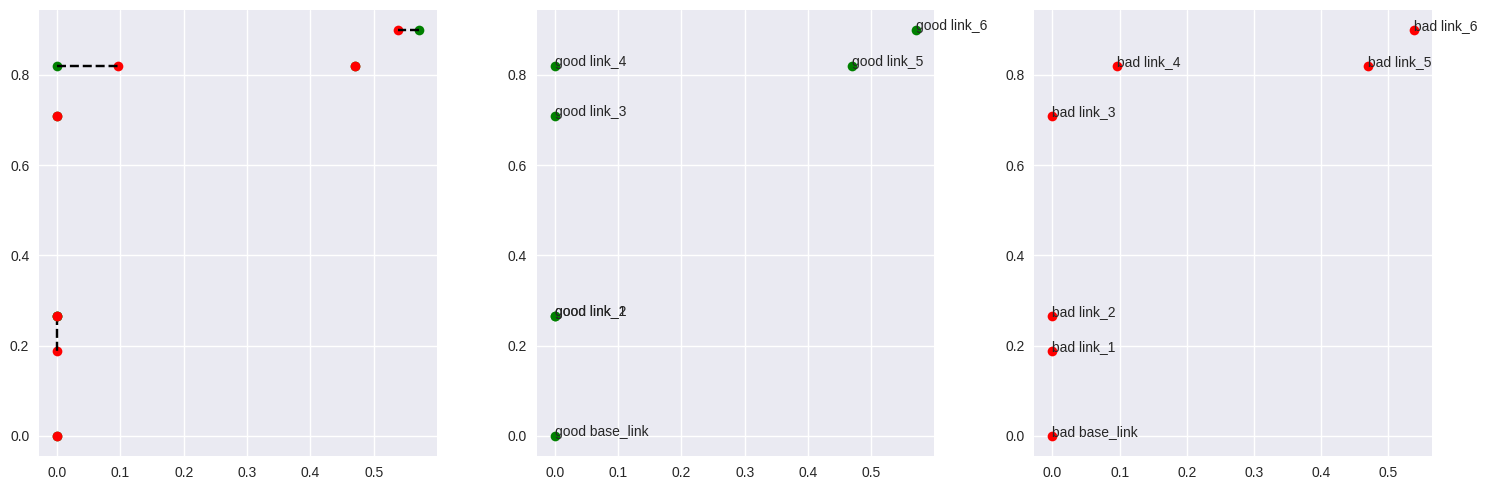

In [36]:

joint_angles_degrees = np.array([0, 0, 0, 0, 0, 0])
expected_flange_xyz = np.array([0.571, 0.0, 0.899])

def fk(urdf: yourdfpy.URDF, joints_degrees: np.ndarray, frame_from="base_link", frame_to="flange") -> np.ndarray:
    urdf.update_cfg(np.deg2rad(joint_angles_degrees))
    result_flange_xyz: np.ndarray = urdf.get_transform(frame_to=frame_to, frame_from=frame_from)[:3, 3]
    return result_flange_xyz

link_names = [
    "base_link",
    "link_1",
    "link_2",
    "link_3",
    "link_4",
    "link_5",
    "link_6",
    # "flange",
]

from dataclasses import dataclass

@dataclass
class Comp:
    name: str
    good_xyz: np.ndarray
    bad_xyz: np.ndarray

# print("Link Name | Good | Bad | Error")
# comps: list[Comp] = []
# for link_name in link_names:
#     good_xyz = fk(good_urdf, joint_angles_degrees, frame_to=link_name)
#     bad_xyz = fk(bad_urdf, joint_angles_degrees, frame_to=link_name)
#     error = good_xyz - bad_xyz
#     print(f"{link_name} | {good_xyz} | {bad_xyz} | {error}")
#     comps.append(Comp(name=link_name, good_xyz=good_xyz, bad_xyz=bad_xyz))

print(f"{'Link Name':<15} | {'Good':<25} | {'Bad':<25} | {'Error':<25}")
print("-" * 95)

comps: list[Comp] = []
for link_name in link_names:
    good_xyz = fk(good_urdf, joint_angles_degrees, frame_to=link_name)
    bad_xyz = fk(bad_urdf, joint_angles_degrees, frame_to=link_name)
    error = good_xyz - bad_xyz
    print(f"{link_name:<15} | {str(good_xyz):<25} | {str(bad_xyz):<25} | {str(error):<25}")
    comps.append(Comp(name=link_name, good_xyz=good_xyz, bad_xyz=bad_xyz))

nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

ax = axes[0]
for comp in comps:
    good_xyz, bad_xyz = comp.good_xyz, comp.bad_xyz
    ax.plot(good_xyz[0], good_xyz[2], 'go')
    ax.plot(bad_xyz[0], bad_xyz[2], 'ro')
    ax.plot([good_xyz[0], bad_xyz[0]], [good_xyz[2], bad_xyz[2]], 'k--')

ax = axes[1]
for comp in comps:
    link_name, good_xyz, bad_xyz = comp.name, comp.good_xyz, comp.bad_xyz
    ax.plot(good_xyz[0], good_xyz[2], 'go')
    ax.text(good_xyz[0], good_xyz[2], f"good {link_name}")

ax = axes[2]
for comp in comps:
    link_name, good_xyz, bad_xyz = comp.name, comp.good_xyz, comp.bad_xyz

    ax.plot(bad_xyz[0], bad_xyz[2], 'ro')
    plt.text(bad_xyz[0], bad_xyz[2], f"bad {link_name}")

plt.tight_layout()
plt.show()
